<a href="https://colab.research.google.com/github/PavelNovikov888/Anomaly_Detection/blob/master/%D0%94%D0%B5%D1%82%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%BD%D0%BE%D0%BC%D0%B0%D0%BB%D0%B8%D0%B9_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Поиск сбоев в системе регулирования температурного режима в помещении.

# Библиотеки и данные

In [531]:
!pip install pyemma --quiet

In [532]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
# PyEMMA (EMMA = Emma's Markov Model Algorithms) Анализ обширных моделей молекулярной динамики.
import pyemma
#  Модели марковского состояния (MSM)
from pyemma import msm

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [533]:
#В колабе импортируем все необходимые библиотеки
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1w5k-VI8JeaAAlQpCE8nczKQZqDyr2sHM"})
# https://drive.google.com/file/d/1w5k-VI8JeaAAlQpCE8nczKQZqDyr2sHM/view?usp=sharing
download.GetContentFile("ambient_temperature_system_failure.zip")

# Вспомогательные функции

In [534]:
# Несколько вспомогательных методов

def getDistanceByPoint(data, model):
    """Расчет расстояний от точек до центров кластеров

    Args:
        data (DataFrame): подготовленные данные
        model (sklearn.cluster.KMeans): обученная модель KMeans

    Returns:
       Series: Список расстояний до центров кластеров
    """
    # список расстояний
    distance = []
    # для каждого наблюдения
    for i in range(0,len(data)):
        # координаты признака данного наблюдения
        Xa = np.array(data.loc[i])
        # print[i]
        # print(Xa)
        # print(model.labels_[i])
        # координаты центра кластера данного наблюдения
        Xb = model.cluster_centers_[model.labels_[i]-1]
        # print(Xb)
        # print(model.labels_[i]-1)
        # рассчитываем норму(длину) вектора от исходной точки до центра кластера
        distance.append(np.linalg.norm(Xa-Xb))
    distance = pd.Series(distance)
    return distance

def getTransitionMatrix (df):
    """Расчет вероятностей перехода к следующему состоянию (глупая предсказывалка)

    Args:
      df (array):  dtrajs ( список, содержащий ndarrays ( dtype=int ) или ndarray ( n , dtype=int ) ) —
       дискретные траектории, хранящиеся как целочисленные ndarrays
       (произвольный размер) или один ndarray только для одной траектории.
        lag ( int ) – время задержки, при котором подсчитываются переходы и оценивается матрица переходов.
    Returns:
        _type_: Оценивает марковскую модель по дискретным траекториям.
        Возвращает объект a MaximumLikelihoodMSM, содержащий предполагаемую матрицу
        перехода и позволяющий вычислить большое количество величин,
        связанных с марковскими моделями.
    """
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def successProbabilityMetric(state1, state2, transition_matrix):
    """Возвращает вероятность успеха изменения состояния

    Args:
        state1 (int): наблюдение
        state2 (int): предыдущее наблюдение
        transition_matrix (int): матрица перехода, рассчитанная по методу Маркова

    Returns:
        int: вероятность успеха изменения состояния
    """
    proba = 0
    # для каждого элемента в матрице перехода
    for k in range(0,len(transition_matrix)):
        # для всех элементов, кроме первого
        if (k != (state2-1)):
            # вероятность = значение из матрицы перехода предыдущая строка и текущий столбец
            proba += transition_matrix[state1-1][k]
    return 1-proba

def sucessScore(sequence, transition_matrix):
    """Возвращает вероятность успеха всей последовательности

    Args:
        sequence (ndarray): данные
        transition_matrix (int): матрица перехода, рассчитанная по методу Маркова

    Returns:
        _type_: _description_
    """
    proba = 0
    # для каждой строки выборки
    for i in range(1,len(sequence)):
        #
        if(i == 1):
            # вернуть вероятность успеха изменения состояния
            proba = successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
        else:
            proba = proba*successProbabilityMetric(sequence[i-1], sequence[i], transition_matrix)
    return proba

def anomalyElement(sequence, threshold, transition_matrix):
    """Возврат, если последовательность является аномалией с учетом порога
    Args:
        sequence (ndarray): данные
        threshold (int): порог
        transition_matrix (int): матрица перехода, рассчитанная по методу Маркова

    Returns:
        int: 0, если вероятность успеха всей последовательности больше порога
            1, если вероятность меньше порога или равна нулю
    """
    if (sucessScore(sequence, transition_matrix) > threshold):
        return 0
    else:
        return 1

def markovAnomaly(df, windows_size, threshold):
    """Поиск аномалий в последовательности сигналов исходя из марковской матрицы переходов
    Args:
        df (ndarray): данные
        windows_size (int):выбор размера скользящего окна (размера оцениваемой последовательности)
        threshold (int): порог

    Returns:
        list: Список аномальных значений, кадр данных, содержащий результат аномалии для всего набора данных
    """
    # расчитаем вероятность перехода к следующему состоянию
    transition_matrix = getTransitionMatrix(df)
    # настоящий порог
    real_threshold = threshold**windows_size
    # список аномалий
    df_anomaly = []
    # для каждого наблюдения в данных
    for j in range(0, len(df)):
      # если номер наблюдения меньше размера скользящего окна
        if (j < windows_size):
            # добавить в список аномалий нулевое значение
            df_anomaly.append(0)
        else: # если номер наблюдения больше размера скользящего окна
            # выбираем строки данных от(текущее наблюдение - размер окна) до текущего наблюдения
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True) # удаляем индексы
            # определяем является ли данная выборка аномалией и добавляем значение 0 или 1 в список
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

# Подготовка данных

In [535]:
# загрузим данные для анализа отказа системы регулирования температуры в помещении
df = pd.read_csv("ambient_temperature_system_failure.zip")

In [536]:
#Посмотрим на данные
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


<Axes: xlabel='timestamp'>

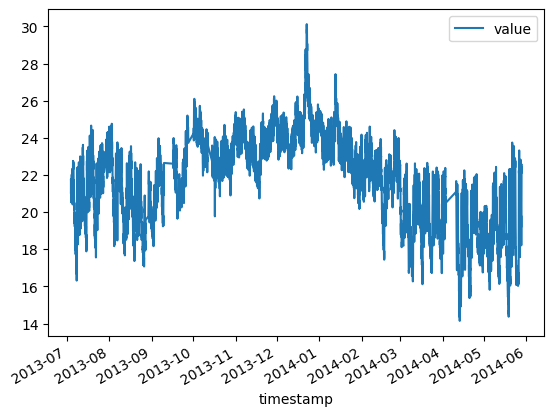

In [537]:
#пересчитаем температуру в цельсии, как привычнее
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5 /9
df.plot(x='timestamp', y='value')

На графике виден тренд восходящий зимой и падающий летом.

In [538]:
#Начнем генерацию фичей
df['hours'] = df['timestamp'].dt.hour
# наблюдение произошло в светлое или нет время суток(1 или 0)
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
# выходной(0) или будний день(1)
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# доля выбросов
outliers_fraction = 0.01

In [539]:
df['daylight']

0       0
1       0
2       0
3       0
4       0
       ..
7262    1
7263    1
7264    1
7265    1
7266    1
Name: daylight, Length: 7267, dtype: int64

In [540]:
# переводим время в числовой формат
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [541]:
df.sample(3)

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch
4650,2014-01-30 13:00:00,22.307602,13,1,3,1,13910868
2789,2013-11-14 00:00:00,24.048923,0,0,3,1,13843872
4701,2014-02-01 16:00:00,22.107194,16,1,5,0,13912704


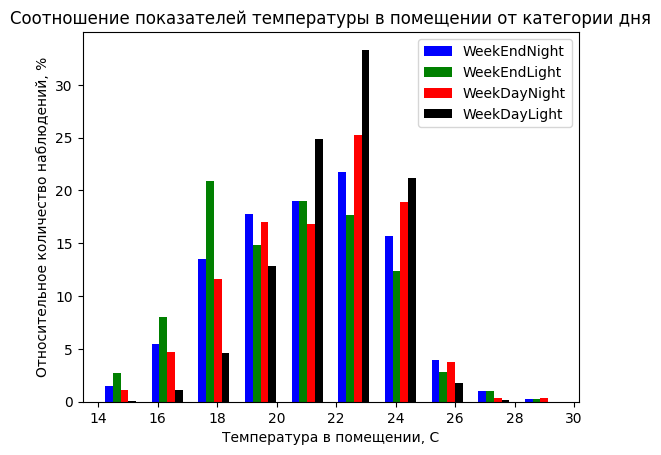

In [542]:
# Хак чтобы получить признак день недели + день-ночь (0 - утро понедельника)
df['categories'] = df['WeekDay']*2 + df['daylight']

# делаем срез данных по категориям
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
# определяем диапазон значений, количество столбцов по умолчанию 10, и количество наблюдений, соответствующее диапазону значений температуры
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

# ширина
width = (a_bins[1] - a_bins[0])/6

# размещаем 4 столбчатых диаграммы рядом
# определяем координаты по оси x, приведем высоту столбцов к относительной величине
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.title("Соотношение показателей температуры в помещении от категории дня")
plt.xlabel("Температура в помещении, С")
plt.ylabel("Относительное количество наблюдений, %")
plt.legend()
plt.show()

# Поиск аномалий с помощью кластеризации

## Подготовка данных

In [543]:
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]

# Нормализуем наши данные
starrd_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = starrd_scaler.transform(data)
data = pd.DataFrame(np_scaled)
# print(data)

# Уменьшим количество компонент
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# print(data)

min_max_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = min_max_scaler.transform(data)
data = pd.DataFrame(np_scaled)
# print(data)

## KMeans

### Поиск оптимального числа кластеров

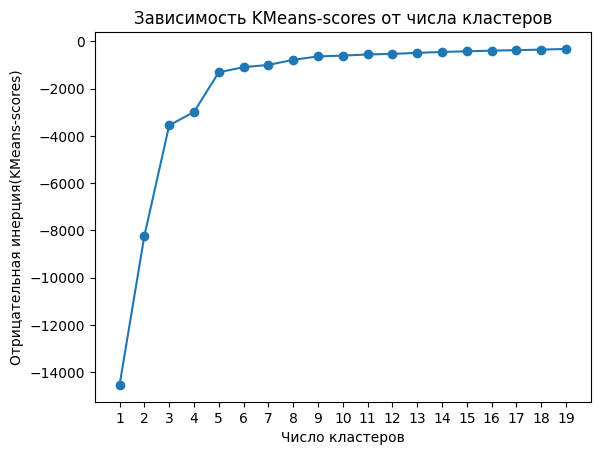

In [544]:
# создаем список количества кластеров 1-19
n_cluster = range(1, 20)
#подберем оптимальное число кластеров k-means
#для этого обучим алгоритм KMeans для заданных чисел кластеров
kmeans = [KMeans(n_clusters=j, n_init = "auto").fit(data) for j in n_cluster]
# получим отрицательную инерцию(score) для разных значений кластеров
scores = [km.score(data) for km in kmeans]

#Подберём число кластеров
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)

ax.scatter(n_cluster, scores)

ax.set(xlim=(0, 20), xticks=np.arange(1, 20))

plt.title("Зависимость KMeans-scores от числа кластеров")
plt.xlabel("Число кластеров")
plt.ylabel("Отрицательная инерция(KMeans-scores)")
plt.show()

Выбираем 4 кластера

In [545]:
kmeans[3]

KMeans(n_clusters=4, n_init='auto')

In [546]:
# кластеризуем подготовленные данные
df['cluster'] = kmeans[3].predict(data)

# разделим главные компоненты
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]

# определим количество наблюдений в каждом кластере
df['cluster'].value_counts()

1    2022
0    1865
3    1858
2    1522
Name: cluster, dtype: int64

In [547]:
kmeans[3].cluster_centers_[:,0]

array([-0.56803634,  1.47885748, -0.25874579, -0.82740061])

### Кластеризация и визуализация данных

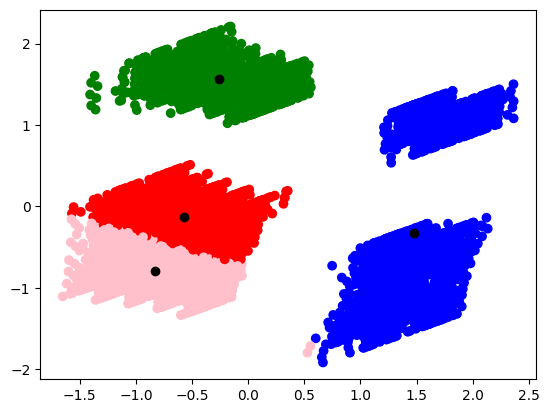

In [548]:
# визуализируем полученные кластеры
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
ax.scatter(kmeans[3].cluster_centers_[:,0], kmeans[3].cluster_centers_[:,1], c = 'black')
plt.show()

## Определение и визуализация аномалий в данных

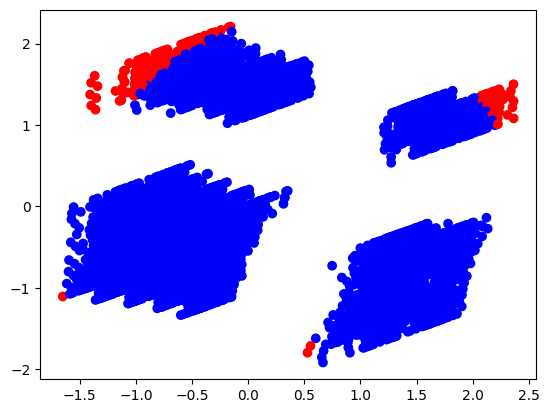

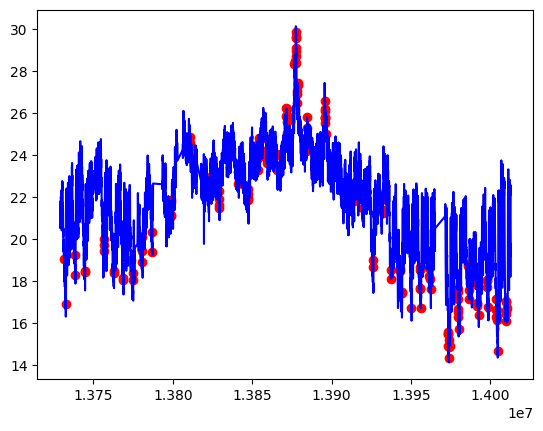

In [549]:
# определим дистанции от точек до центров соседних кластеров
distance = getDistanceByPoint(data, kmeans[3])
# количество выбросов
number_of_outliers = int(outliers_fraction*len(distance))
# минимальное значение из 72 наибольших значений дистанции
threshold = distance.nlargest(number_of_outliers).min()

# Считаем точку аномалией, если расстояние до центра кластера больше порога
df['anomaly21'] = (distance >= 3.0).astype(int)

# визуализируем аномалии на точечном графике
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
# окрашиваем точки в зависимости от того, аномалия это или нет
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

# визуализируем аномалии на точечном графике
fig, ax = plt.subplots()
a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #данные об аномальных наблюдениях

# линейный график наблюдений
ax.plot(df['time_epoch'], df['value'], color='blue')
# точечный график аномалий
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<Figure size 2000x500 with 0 Axes>

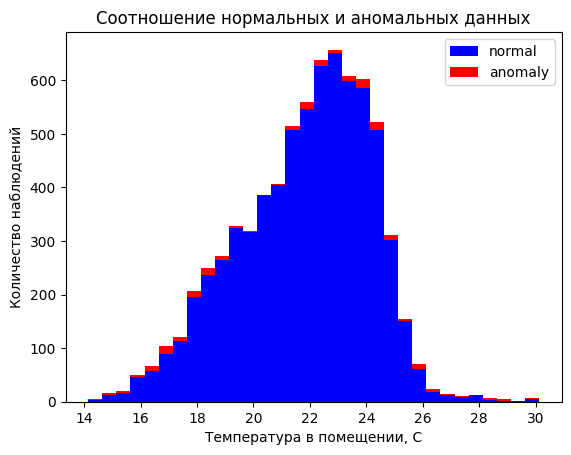

In [550]:
# Посмотрим на распределение аномальных и действительных значений
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig = plt.figure(figsize=(20, 5))
fig, axs = plt.subplots()

axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

# Заголовок таблицы
plt.title("Соотношение нормальных и аномальных данных")
# Подписи осей
plt.xlabel("Температура в помещении, С")
plt.ylabel("Количество наблюдений")
plt.legend()
plt.show()

Распределения похожи

In [551]:
# создадим 4 различных набора данных на основе определенных ранее категорий
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']


<Axes: >

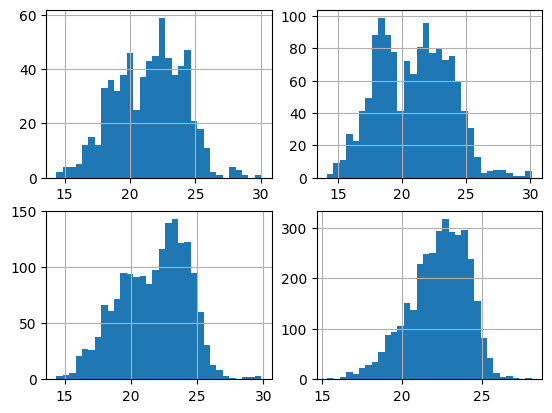

In [552]:
# построим гистограммы данных категорий
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

# Определение аномалий с помощью EllipticEnvelope

In [553]:
# Попробуем статистически оценить количество аномалий
# EllipticEnvelope предполагает, что данные являются гауссовскими, и изучает эллипс.
# Таким образом, он ухудшается, когда данные не являются одномодальными(одна вершина(мода))
# contamination Степень загрязнения набора данных, т.e. доля выбросов в наборе данных.
envelope =  EllipticEnvelope(contamination = outliers_fraction)
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction)
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction)
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction)
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

<Figure size 2000x2000 with 0 Axes>

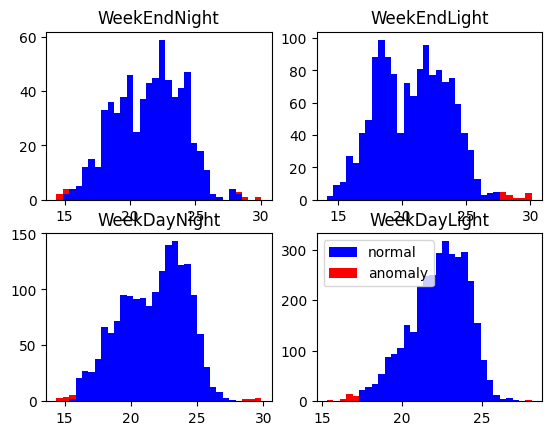

In [554]:
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

plt.figure(figsize=(20,20))
fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [555]:
# объединим данные и пометим аномалии
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int)

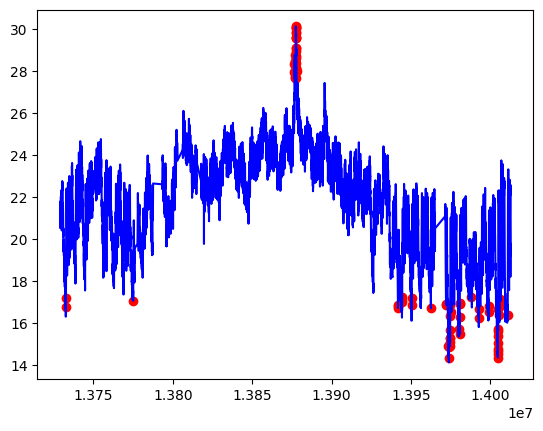

In [556]:
# визуализация аномалии во времени (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()


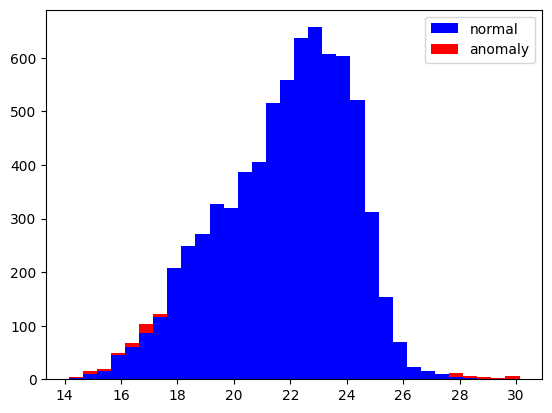

In [557]:
# визуализация аномалии с температурным перераспределением (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

# Детектирование аномалий с помощью IsolationForest

In [566]:
# Подготовим данные
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]

# Обучим модель IsolationForest
model =  IsolationForest(contamination=0.1, random_state=13).fit(data)

# сделаем предсказание с помощью модели IsolationForest
df['anomaly25'] = pd.Series(model.predict(data))
# заменим значения на необходимые для дальнейших действий
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )

print(df['anomaly25'].value_counts())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


0.0    6538
1.0     727
Name: anomaly25, dtype: int64


In [567]:
df.head()

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,cluster,principal_feature1,principal_feature2,anomaly21,anomaly22,anomaly25,value_diff,anomaly26
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2,2,-0.009413,1.647609,0,0,0.0,0.744107,0.0
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2,2,-0.009359,1.577677,0,0,0.0,-0.190234,0.0
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2,2,0.061592,1.543184,0,0,0.0,-1.065781,0.0
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2,2,0.031660,1.458262,0,0,0.0,0.180084,0.0
5,2013-07-04 05:00:00,21.144981,5,0,3,1,13729140,2,2,-0.018663,1.363146,0,0,0.0,0.431897,0.0


In [559]:
# определим изменение показаний от часа к часу
df['value_diff'] = df['value'].diff(1)
# удалим пропуски
df.dropna(inplace=True)

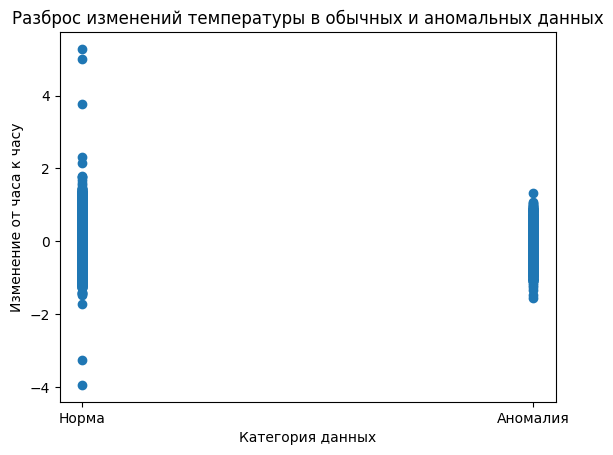

In [588]:
# визулизируем разброс изменений температуры в обычных и аномальных данных

fig, ax = plt.subplots()
plt.scatter(df['anomaly25'], df['value_diff'])
ax.set_xticks(range(0,2), ['Норма', 'Аномалия'])
# Заголовок таблицы
plt.title("Разброс изменений температуры в обычных и аномальных данных")
# Подписи осей
plt.xlabel("Категория данных")
plt.ylabel("Изменение от часа к часу")
plt.show()

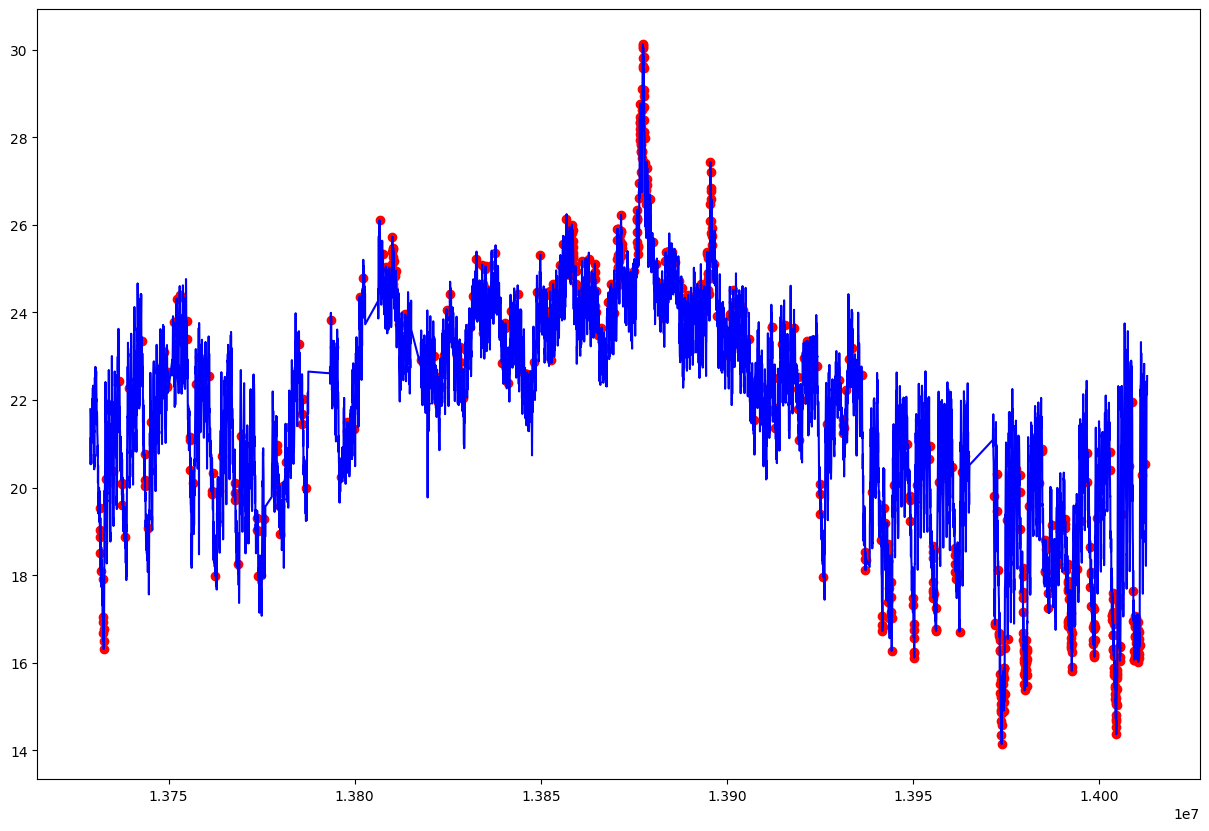

In [561]:
# визуализация аномалии во времени (viz 1)
plt.figure(figsize=(15, 10))

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

plt.plot(df['time_epoch'], df['value'], color='blue')
plt.scatter(a['time_epoch'],a['value'], color='red')
plt.show()


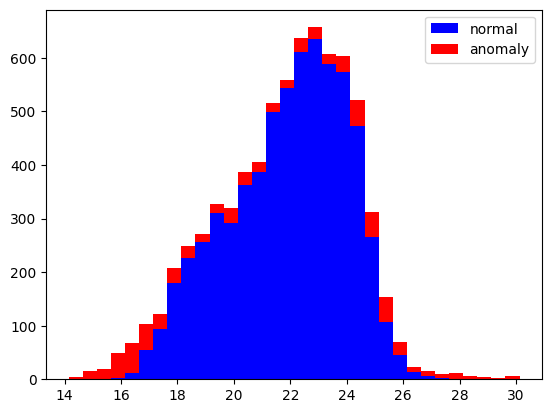

In [562]:
# визуализация аномалии с температурным перераспределением (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

# Детектирование аномалий с помощью SVM(Метод опорных векторов)  

## Подготовка данных

In [589]:
# Применим OneClassSvm
from sklearn.preprocessing import MinMaxScaler

data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
# нормализуем данные
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)

# создадим и обучим модель SVM
model = OneClassSVM()
data = pd.DataFrame(np_scaled)
model.fit(data)

# выполним классификацию данных
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())


1.0    3634
0.0    3631
Name: anomaly26, dtype: int64


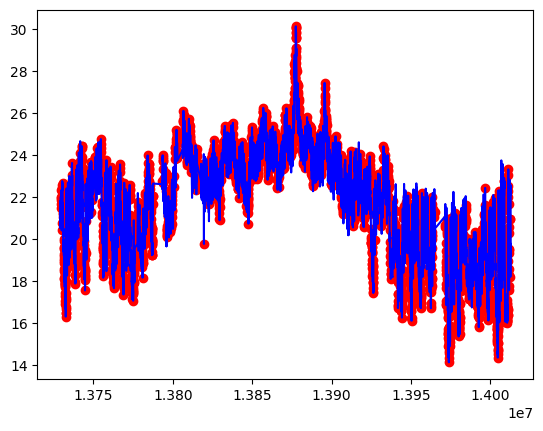

In [590]:
# визуализация аномалии во времени (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

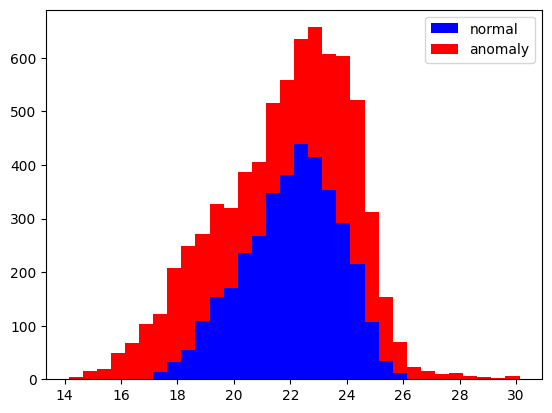

In [565]:
# визуализация аномалии с температурным перераспределением (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()